2. Using a dictionary in qdapDictionaries, conduct sentiment analysis on your corpus. Write up the results in a pdf and interpret them.

Submit the answers to both assignment questions in a single pdf. file.

# Setup

In [1]:
import os as os
import sys as sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#torch goodness
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#huggingface goodness
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

#set graph config
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

#set seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#check gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load training datasets

In [2]:
# https://www.kaggle.com/lava18/google-play-store-apps
# google play app reviews ~16k
df_google = pd.read_csv("google_reviews.csv")

# imdb from http://ai.stanford.edu/~amaas/data/sentiment/
# "We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing."
# this file was larger than 100mb (github's file size limit)
df_imdb = pd.read_csv('imdb_reviews.csv')

# Preprocess training datasets

### imdb

In [3]:
# first look, includes .head() shape and missing values
def first_look(df):
    # gives basic info about the df
    lst =[df.head(0), df.shape, df.info()]
    for item in lst:
        print(item)
        print('-------------------------------------------------')

In [4]:
# first look
first_look(df_imdb)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   content    100000 non-null  object
 1   sentiment  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
Empty DataFrame
Columns: [content, sentiment]
Index: []
-------------------------------------------------
(100000, 2)
-------------------------------------------------
None
-------------------------------------------------


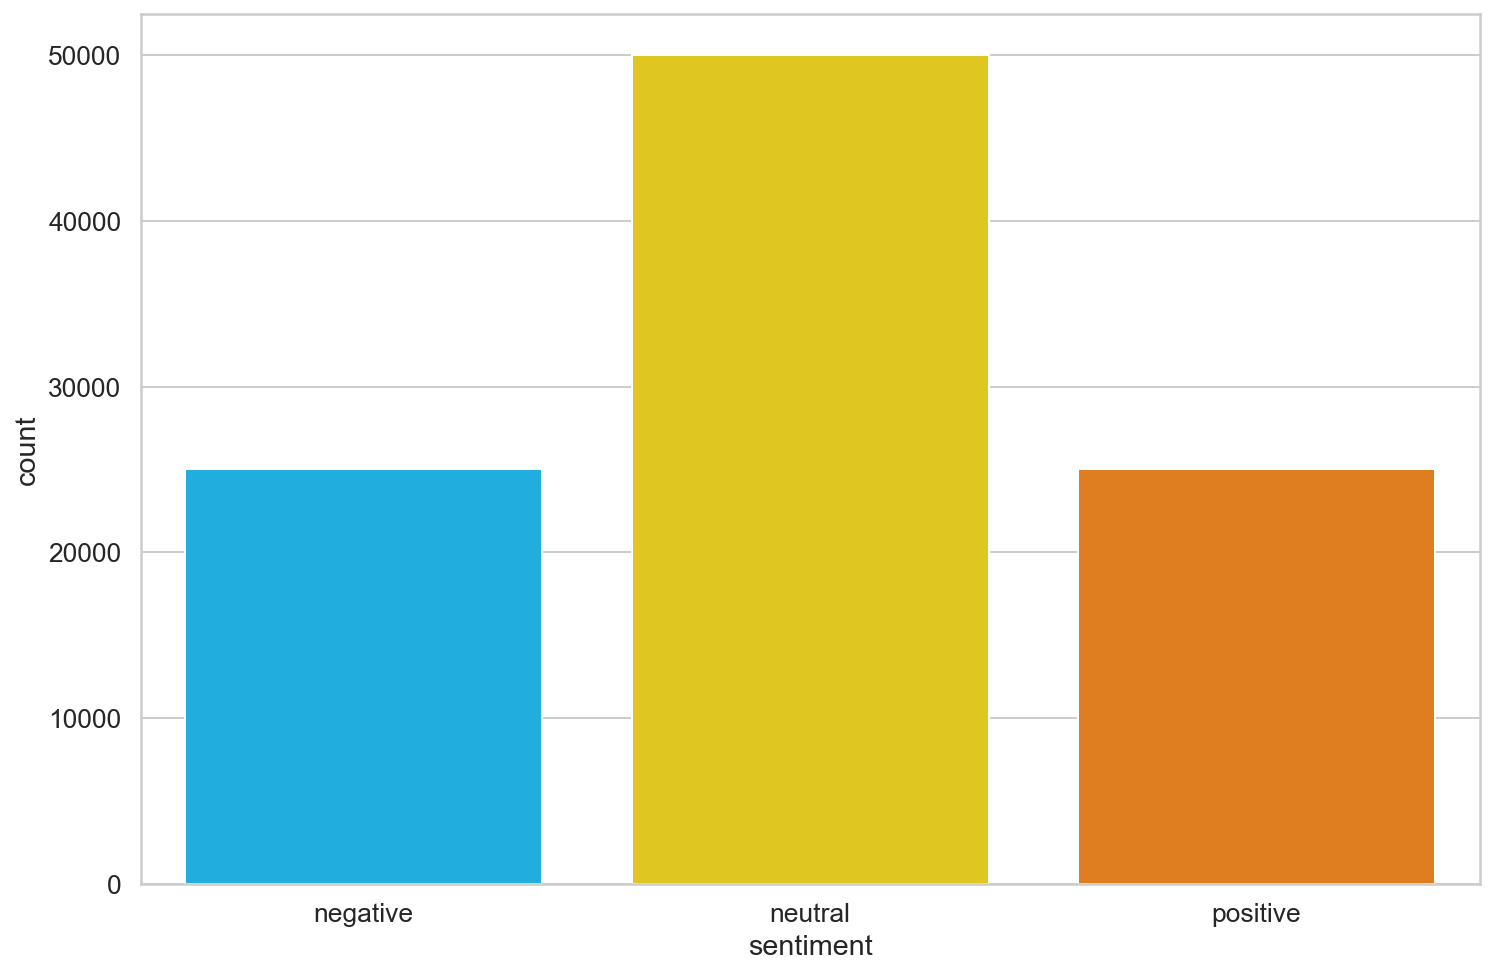

In [5]:
# let's look at the scores

# 0 = negative
# 1 = neutral 
# 2 = postitive

#review changes
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df_imdb.sentiment)
plt.xlabel('review sentiment')
sns.countplot(df_imdb.sentiment)
ax.set_xticklabels(class_names);

### google 

In [6]:
# first look
first_look(df_google)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB
Empty DataFrame
Columns: [userName, userImage, content, score, thumbsUpCount, reviewCreatedVersion, at, replyContent, repliedAt, sortOrder, appId]
Index: []
----------------------------------

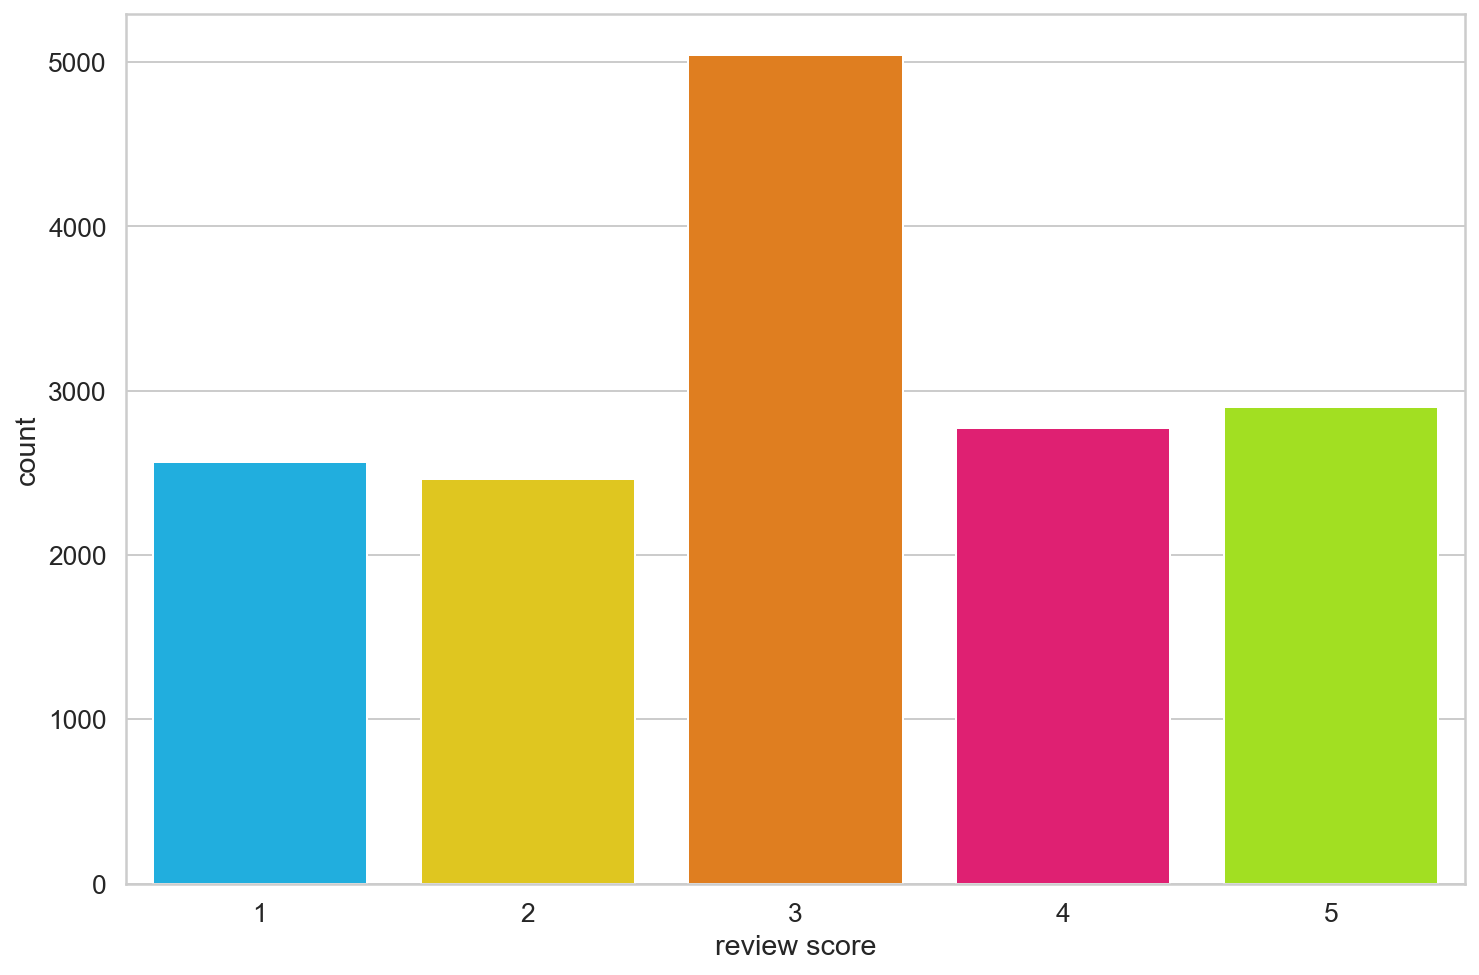

In [7]:
# Let's look at the scores
sns.countplot(df_google.score)
plt.xlabel('review score');

In [8]:
# dimension reduction
def to_sentiment(rating):
    #restruture review scores to emulate imdb
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

#apply above function to dataset
df_google['sentiment'] = df_google.score.apply(to_sentiment)

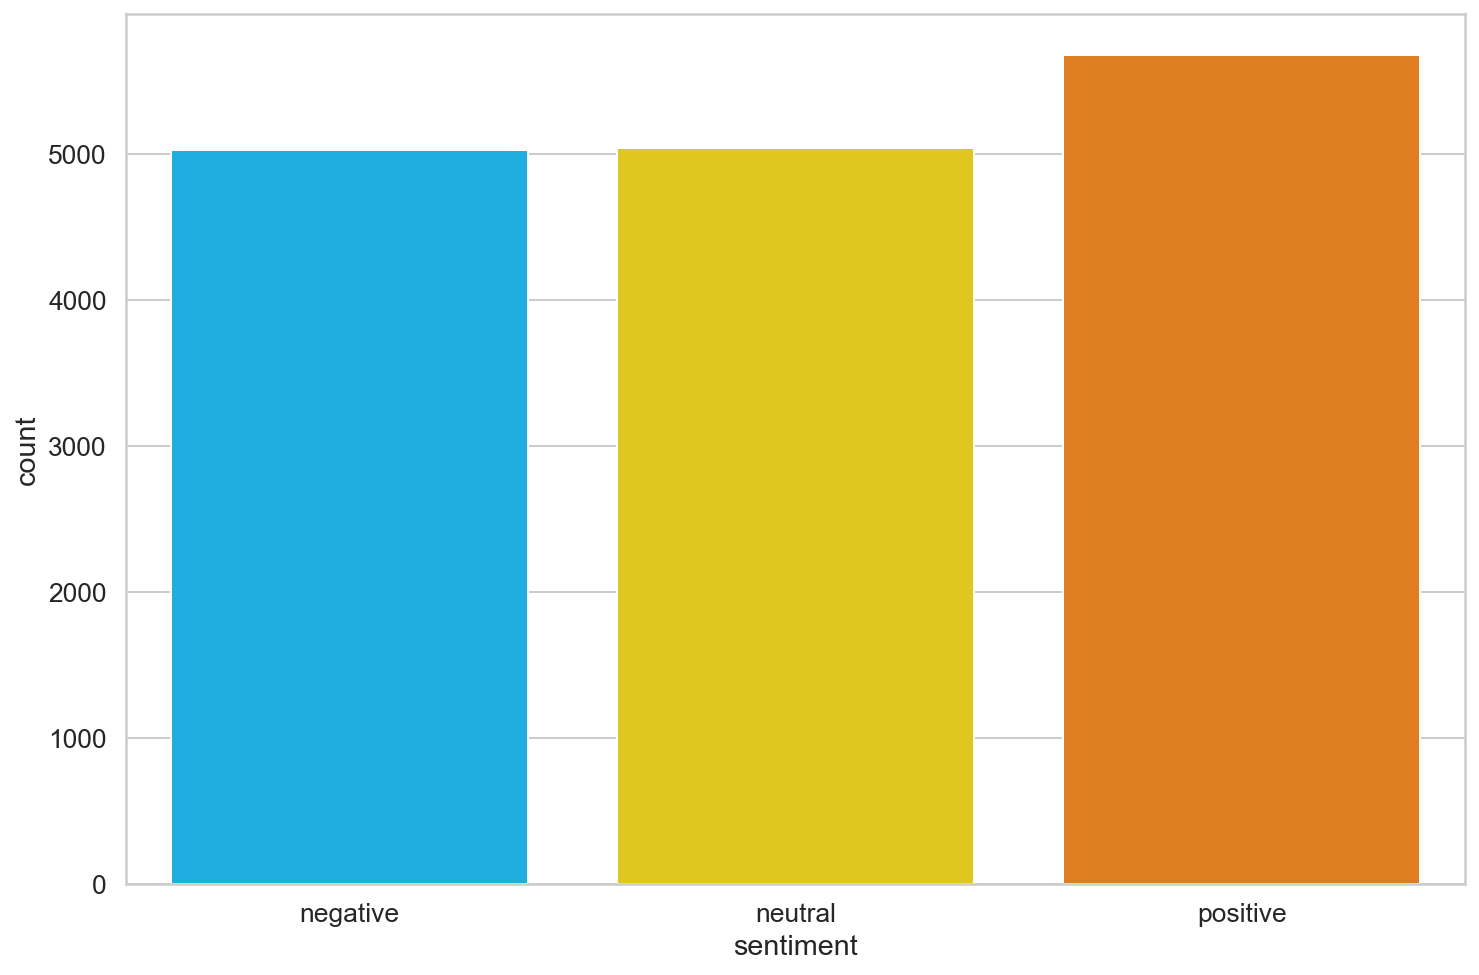

In [9]:
#review changes
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df_google.sentiment)
plt.xlabel('review sentiment')
sns.countplot(df_google.sentiment)
ax.set_xticklabels(class_names);

In [10]:
# merge google and imdb datasets and rename to 'df'

#subset google for relavent info
df_google_subset = df_google[['content', 'sentiment']]

frames = [df_google_subset, df_imdb] #I omitted df_imdb, due to limited gpu memory
df = pd.concat(frames)

# Tokenize training dataset

In [11]:
# load pre-trained bert model
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

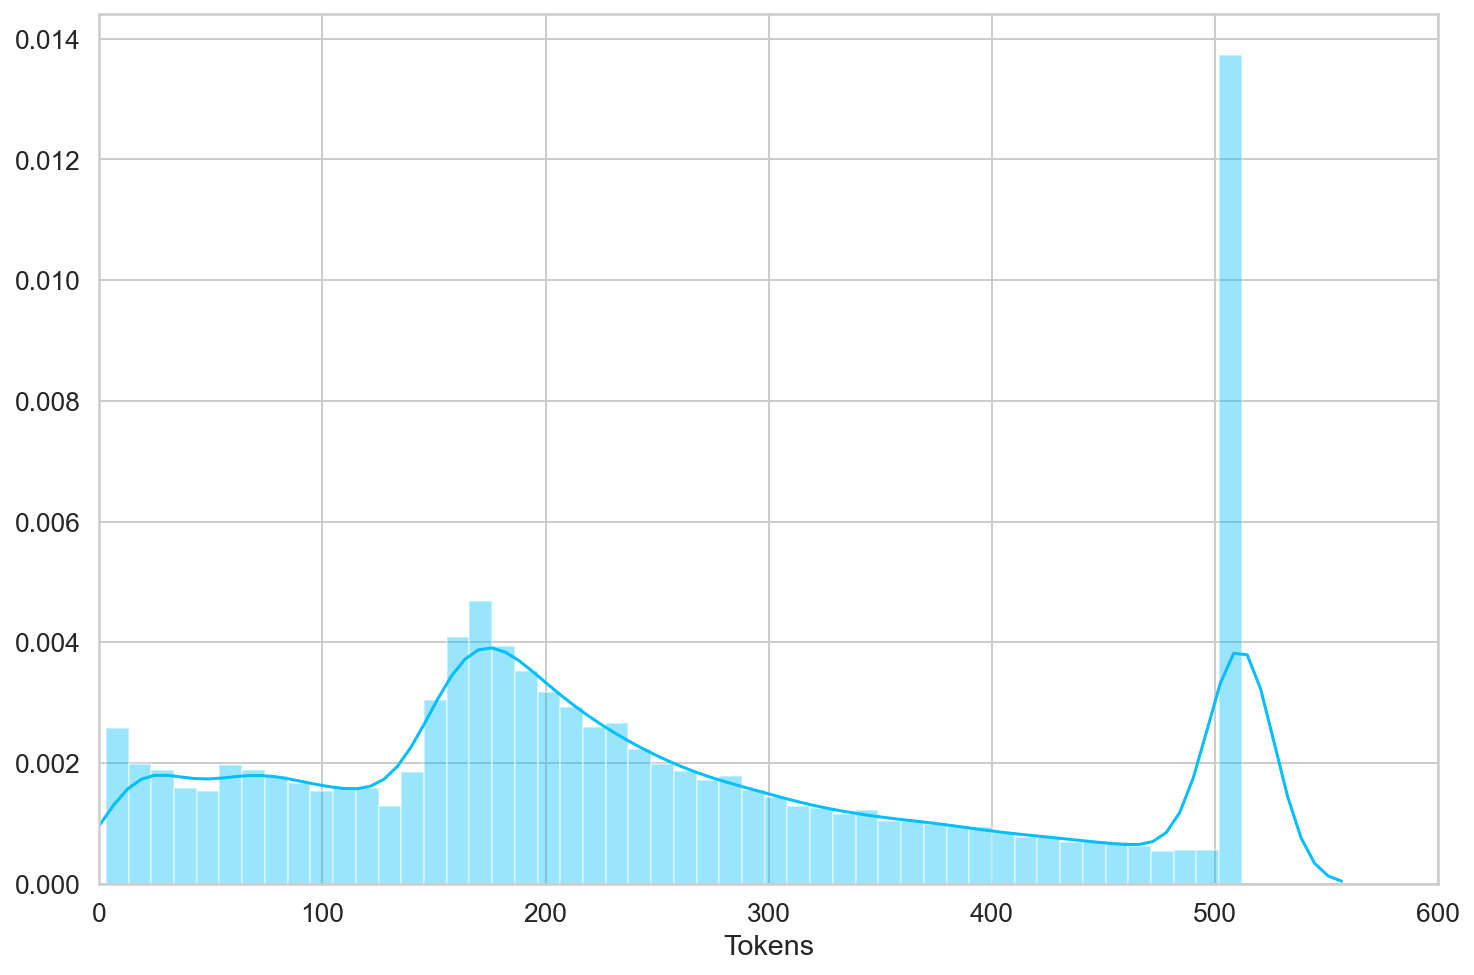

In [12]:
def tokenize_inspect(df):
    #BERT works with fixed-length sequences. Let's inspect the length of each review from our training dataset and tokenize it
    token_lens = []
    for txt in df.content:
        tokens = tokenizer.encode(txt, max_length=512)
        token_lens.append(len(tokens))

    #let's plot the distribution to get a sense of what we're working with
    sns.distplot(token_lens)
    plt.xlim([0, 600]);
    plt.xlabel('Tokens');
    
# pass training dataset into tokenizer/inspection
tokenize_inspect(df)

In [13]:
# select max len of tokens you want to train with
MAX_LEN = 512

In [14]:
#class that formatts df into pytorch format
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [15]:
#text train split data
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)
df_train.shape, df_val.shape, df_test.shape

((104171, 2), (5787, 2), (5788, 2))

In [16]:
#We also need to create a couple of data loaders. Here’s a helper function to do it:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
        )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
        )

#set batch size and load data
BATCH_SIZE = 6
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [17]:
#let's look at an example batch from out trining data loader:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [18]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([6, 512])
torch.Size([6, 512])
torch.Size([6])


# Sentiment Classification with BERT and Hugging Face

In [19]:
#load classification model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [20]:
#BERT sentiment classifier
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [21]:
# create instance and send to gpu
model = SentimentClassifier(len(class_names))
model = model.to(device)

### Training

In [22]:
#To reproduce the training procedure from the BERT paper, 
#we’ll use the AdamW optimizer provided by Hugging Face. 
#It corrects weight decay, so it’s similar to the original paper. 
#We’ll also use a linear scheduler with no warmup steps:

EPOCHS = 8
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [23]:
#Let’s continue with writing a helper function for training our model for one epoch:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
  ):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
# Let’s write another one that helps us evaluate the model on a given data loader:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
# Using those two, we can write our training loop. We’ll also store the training history:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:    #fail safe 
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/8
----------
Train loss 0.8774667557248692 accuracy 0.5066957214579874
Val   loss 0.7981795329658479 accuracy 0.5370658372213583

Epoch 2/8
----------
Train loss 0.7630588364406653 accuracy 0.569957089785065
Val   loss 0.8273673069909446 accuracy 0.5864869535165025

Epoch 3/8
----------
Train loss 0.6457545513596376 accuracy 0.6725000239990017
Val   loss 0.8832363110981457 accuracy 0.6298600311041991

Epoch 4/8
----------
Train loss 0.5320984290100295 accuracy 0.757331695001488
Val   loss 1.0803210905410465 accuracy 0.6543977881458442

Epoch 5/8
----------
Train loss 0.4559454993351911 accuracy 0.8275911722072362
Val   loss 1.3110616145286362 accuracy 0.6735787109037498

Epoch 6/8
----------
Train loss 0.4112388017466228 accuracy 0.8803697766172928
Val   loss 1.6492975974200328 accuracy 0.682909970623812

Epoch 7/8
----------
Train loss 0.3486214365502643 accuracy 0.9170114523235834
Val   loss 1.8700992764502467 accuracy 0.6856747883186453

Epoch 8/8
----------
Train loss 0.279

In [ ]:
#started at 8:18 pm
#ended at 11:08 am

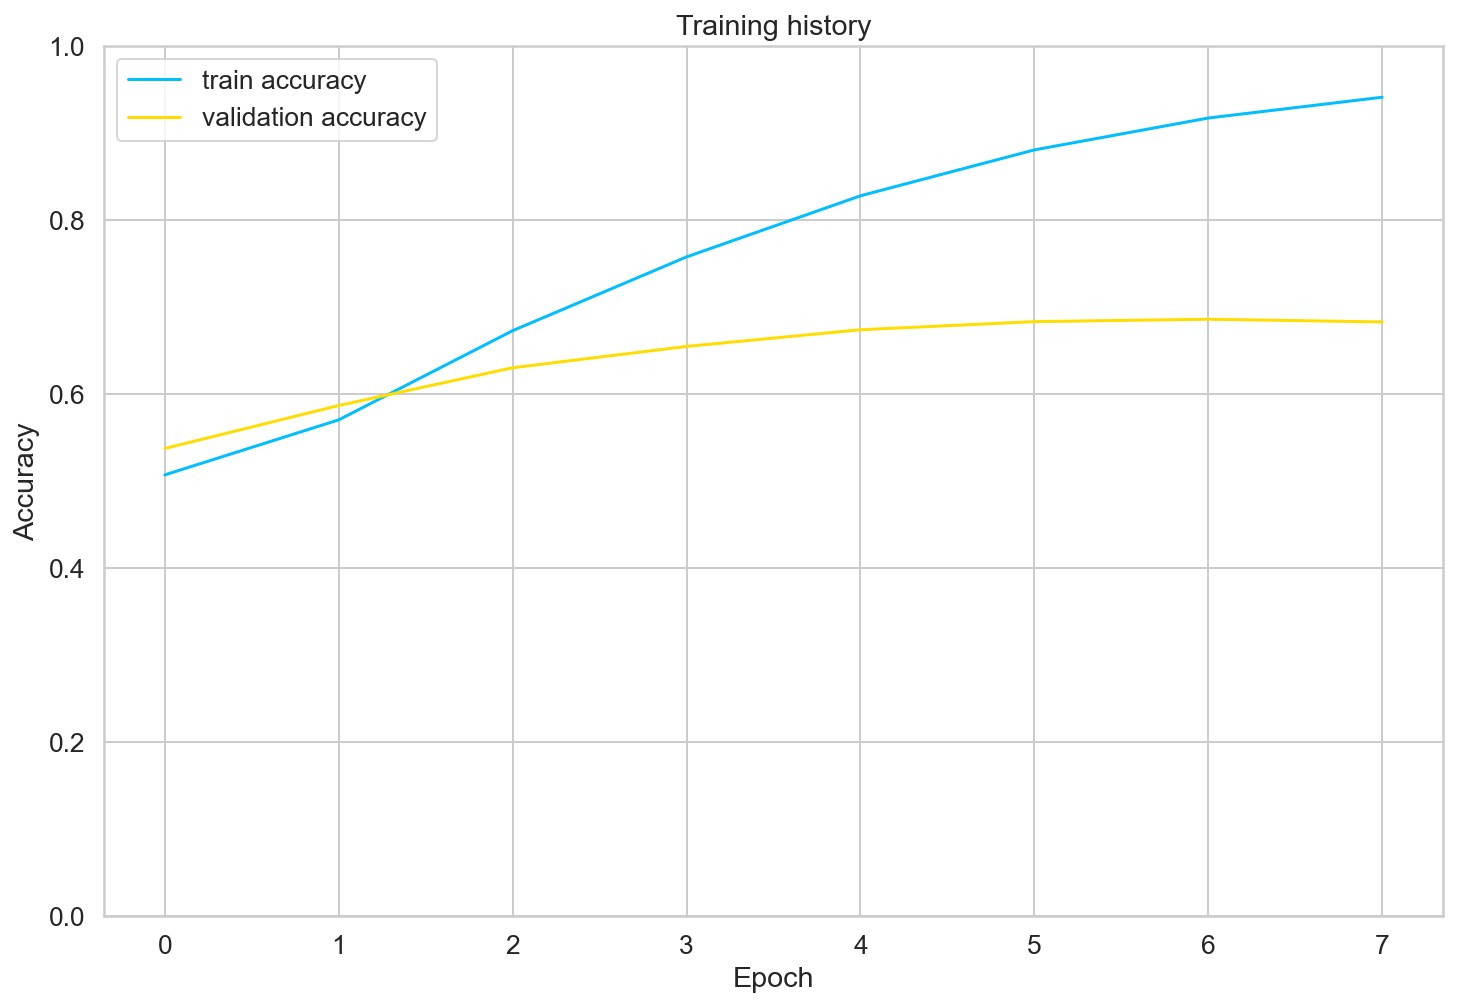

In [26]:
#note that my validation accuracy went down as a result of adding the new training data

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Predicting Raw Text

In [27]:
# load raw text
df_game_reviews = pd.read_csv("game_reviews.csv")

In [28]:
# inspect
first_look(df_game_reviews)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51321 entries, 0 to 51320
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   recommendationid                51321 non-null  int64  
 1   language                        51321 non-null  object 
 2   review                          51270 non-null  object 
 3   timestamp_created               51321 non-null  object 
 4   timestamp_updated               51321 non-null  object 
 5   voted_up                        51321 non-null  bool   
 6   votes_up                        51321 non-null  int64  
 7   votes_funny                     51321 non-null  int64  
 8   weighted_vote_score             51321 non-null  float64
 9   comment_count                   51321 non-null  int64  
 10  steam_purchase                  51321 non-null  bool   
 11  received_for_free               51321 non-null  bool   
 12  written_during_early_access     

In [33]:
# subset df to just english reviews
df_english = df_game_reviews[df_game_reviews["language"] == 'english']

In [35]:
# set reviews to list
title_lst = df_english['review'].tolist()

In [39]:
title_lst_final = []

for item in title_lst:
    temp = str(item)
    title_lst_final.append(temp)

In [41]:
# pass each review through sentiment model
review_text_lst = []
prediction_lst = []

for item in title_lst_final:
    encoded_review = tokenizer.encode_plus(item, max_length=MAX_LEN, 
                                           add_special_tokens=True, 
                                           return_token_type_ids=False, 
                                           pad_to_max_length=True, 
                                           return_attention_mask=True, 
                                           return_tensors='pt',)
    
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    
    review_text_lst.append(item)
    prediction_lst.append(class_names[prediction])

In [42]:
#count up your glorious sentiment results
pos_count = 0
neg_count = 0
neu_count = 0

for item in prediction_lst:
    if item == 'positive':
        pos_count += 1
    elif item == 'neutral':
        neu_count += 1
    else:
        neg_count += 1

In [43]:
print('Positive articles: ', pos_count)
print('Negative articles: ', neg_count)
print('Neutral articles: ', neu_count)

Positive articles:  14855
Negative articles:  4772
Neutral articles:  11858


In [53]:
df = pd.DataFrame(prediction_lst)

In [59]:
df_english.to_csv('english_game_reviews.csv')
df.to_csv('prediction_lst.csv')


Crystal Feel http://www.crystalfeel.socialanalyticsplus.net/ 
Crystal Feel Manual http://52.3.21.155/crystalfeel/[CrystalFeel]_User_Manual.pdf
Super Cool App Thingy https://medium.com/@mirzamujtaba10/sentiment-analysis-642b935ab6f9
NLP survey @17:00 https://www.youtube.com/watch?v=G5lmya6eKtc&t=1075s
Cool NLP data size paper: https://arxiv.org/abs/2001.08361![http---52.3.21.155-crystalfeel-[CrystalFeel]_User_Manual.pdf.url](attachment:http---52.3.21.155-crystalfeel-[CrystalFeel]_User_Manual.pdf.url)